In [ ]:
%cd ..

import torch
import time
import numpy as np

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit

from src.nn.measurements.default import default_measurement

from src.utils.dataset import load_dataset
from src.utils.load_params import load_params
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer


import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

In [2]:
limit = 100
dataset_ = "EuroSAT"
image_size = 28
test_size = 0.2
output = 'np' # 'np' or 'dl'
    
if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']
    
config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True



Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


## Choose params - FlexHybridCNN

In [3]:
embedding_type, circuit, measurement = "waterfall", no_entanglement_random_circuit, default_measurement

use_quantum, log_wandb, plot = False, False, True

learning_rate, epochs, qkernel_shape, n_classes = 0.01, 10, 2, len(allowed_classes)

early_stopping, patience = True, 4

in_channels_1, in_channels_2, qkernel_shape, kernel_size_1, kernel_size_2, quanv_params, name_run, name_prueba, prename= load_params(embedding_type, circuit, measurement, limit, dataset_, qkernel_shape, use_quantum)

experiment_name = prename + embedding_type + "_" + circuit.__name__ + "_" + str(limit) + ","
print(dataset_)

EuroSAT


#### Train model

In [4]:
model_flexhybrid = FlexHybridCNN(n_classes = n_classes, 
                      use_quantum = use_quantum,
                      in_channels_1 = in_channels_1,
                      in_channels_2 = in_channels_2,
                      qkernel_shape = qkernel_shape,
                      kernel_size_1 = kernel_size_1,
                      kernel_size_2 = kernel_size_2,
                      quanv_params = quanv_params,
                     )

trainer = Trainer(model = model_flexhybrid,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log_wandb = log_wandb,
                  wandb_project = name_prueba,
                  wandb_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate
                 )

Epoch [1/10]: Train Loss = 2.2323, Train Acc = 19.38%, Val Loss = 2.1658, Val Acc = 18.00%
Epoch [2/10]: Train Loss = 1.9641, Train Acc = 28.50%, Val Loss = 2.0430, Val Acc = 27.00%
Epoch [3/10]: Train Loss = 1.9393, Train Acc = 26.50%, Val Loss = 1.9083, Val Acc = 31.00%
Epoch [4/10]: Train Loss = 1.7205, Train Acc = 35.00%, Val Loss = 1.9427, Val Acc = 30.00%
Epoch [5/10]: Train Loss = 1.7694, Train Acc = 35.38%, Val Loss = 2.0042, Val Acc = 27.00%
Epoch [6/10]: Train Loss = 1.6360, Train Acc = 37.12%, Val Loss = 1.8786, Val Acc = 32.50%
Epoch [7/10]: Train Loss = 1.5099, Train Acc = 43.00%, Val Loss = 1.7741, Val Acc = 30.50%
Epoch [8/10]: Train Loss = 1.5390, Train Acc = 40.75%, Val Loss = 1.9056, Val Acc = 30.00%
Epoch [9/10]: Train Loss = 1.5587, Train Acc = 45.38%, Val Loss = 1.9457, Val Acc = 28.00%
Epoch [10/10]: Train Loss = 1.4065, Train Acc = 45.88%, Val Loss = 1.8656, Val Acc = 40.00%


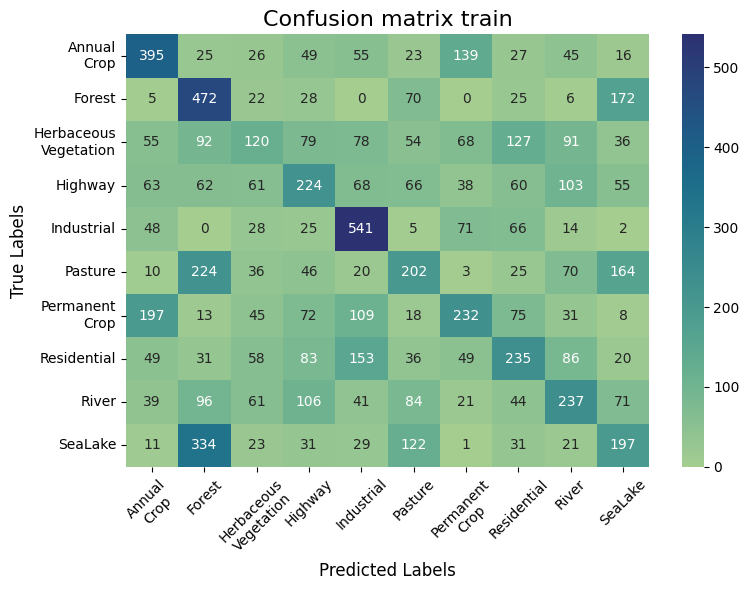

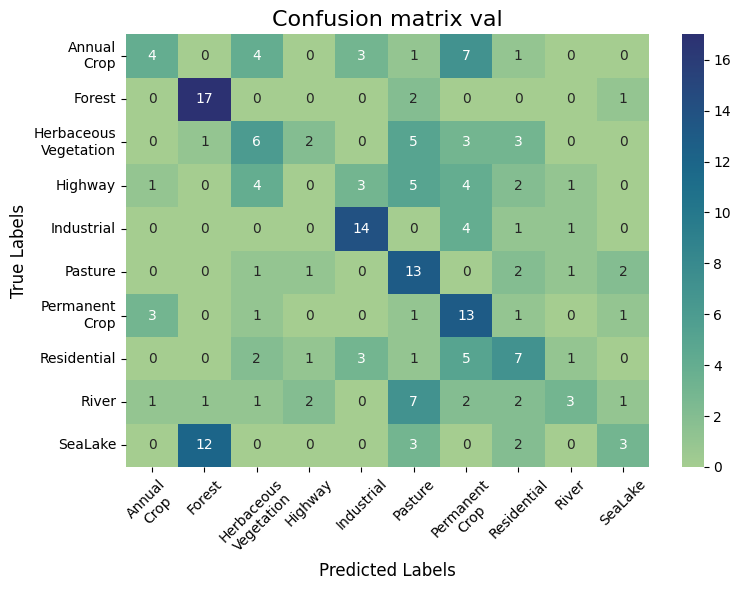

Tiempo de entrenamiento: 0 minutos y 23 segundos


In [5]:
t0 = time.time()
trainer.fit()
t1 = (time.time()-t0)/60
print(f"Tiempo de entrenamiento: {int(t1)} minutos y {int(np.round((t1-int(t1))*60,0))} segundos")